In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

## Dataset Load

In [3]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5) )])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 32
train_loader = DataLoader(trainset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size= batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


### 이미지 시각화

In [7]:
def imshow(image):
    image = image / 2 + 0.5    # 이미지 정규화
    np_image = image.numpy()   # Tensor를 Numpy화
    plt.imshow(np.transpose(np_image, (1,2,0)))

In [5]:
train_iter = iter(train_loader)
data, target = train_iter.next()
data.shape, target.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

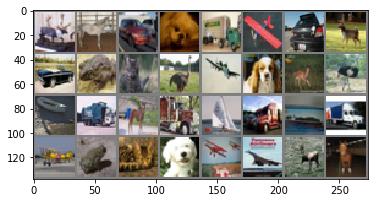

In [8]:
imshow(torchvision.utils.make_grid(data))

## Building Network Model

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32*5*5, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        return x

In [10]:
# model 생성
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### Optimizer 및 Loss Function

In [11]:
optim = torch.optim.Adam(params=model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

## Train and Evaluation

In [17]:
epochs = 3
train_loss = 0
for epoch in range(1, epochs+1):
    model.train()  # Train 모드
    for batch_index, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)   # Cuda 또는 cpu 설정
        
        optim.zero_grad()    # gradient 초기화
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optim.step()
        
        train_loss += loss
        
        if batch_index % 100 == 0:
            print('Epoch:{}, [{}/{} ({}%)]   Loss: {:.5f}'.format(epoch, batch_index*batch_size, len(train_loader.dataset),
                                                           100*batch_index*batch_size/len(train_loader.dataset)   , train_loss/100))
            train_loss = 0
            
    model.eval()  # Eval 모드
    test_loss = 0
    correct = 0
    with torch.no_grad():   # 불필요한 Gradient 계산 끄기
        for (data, target) in test_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            test_loss += loss_function(output, target).item()
            pred = torch.argmax(output, dim=1)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.5f}, Accuracy: {}%'.format(test_loss, 100*correct/len(test_loader.dataset)))

Epoch:1, [0/50000 (0.0%)]   Loss: 0.01641
Epoch:1, [3200/50000 (6.4%)]   Loss: 1.54724


KeyboardInterrupt: 